In [ ]:
#datetime
from datetime import datetime, timedelta
from dateutil.parser import parse

#common library for analysis and visualization
import numpy as np             
import pandas as pd
from scipy import stats 
import itertools
import statsmodels.api as sm           
import matplotlib.pylab as plt
import seaborn as sns 

# stationarity test
from statsmodels.tsa.stattools import adfuller

#acf, pacf
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

#check seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

#arima model
from statsmodels.tsa.arima_model import ARIMA

#mean square error
from sklearn.metrics import mean_squared_log_error


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

!pip install pmdarima
import pmdarima as pm
%matplotlib inline   

### Read_data

In [ ]:
df_train = pd.read_csv('drive/My Drive/bri_hackaton/train.csv')
df_train.head()

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [ ]:
df_train.isnull().sum()

periode                       0
cash_in_echannel              0
cash_out_echannel             0
cash_in_kantor                0
cash_out_kantor               0
cr_ketetapan_total_bkn_sum    0
giro                          0
deposito                      0
kewajiban_lain                0
tabungan                      0
rata_dpk_mingguan             0
kas_kantor                    0
kas_echannel                  0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   periode                     425 non-null    object 
 1   cash_in_echannel            425 non-null    float64
 2   cash_out_echannel           425 non-null    float64
 3   cash_in_kantor              425 non-null    float64
 4   cash_out_kantor             425 non-null    float64
 5   cr_ketetapan_total_bkn_sum  425 non-null    float64
 6   giro                        425 non-null    float64
 7   deposito                    425 non-null    float64
 8   kewajiban_lain              425 non-null    float64
 9   tabungan                    425 non-null    float64
 10  rata_dpk_mingguan           425 non-null    float64
 11  kas_kantor                  425 non-null    float64
 12  kas_echannel                425 non-null    float64
dtypes: float64(12), object(1)
memory us

In [ ]:
#change period to datetime
df_train['periode'] = pd.to_datetime(df_train['periode'],infer_datetime_format=True)

#change column periode to index
new_df = df_train.set_index(['periode'])

###check missing date

In [ ]:
missing_date = pd.date_range(start=new_df.index[0], end=new_df.index[-1]).difference(new_df.index)
missing_date

DatetimeIndex(['2020-06-20', '2020-06-24', '2020-08-27'], dtype='datetime64[ns]', freq=None)

antara tahun 2019 - 2020, terdapat tiga tanggal yang tidak memiliki data, karena hanya tiga tanggal, maka kita akan mengisinya menggunakan interpolarate time

In [ ]:
### create list date contain missing date
new_date =  pd.date_range(start=new_df.index[0], end=new_df.index[-1])

### input missing date with nan and create new df contain cash echannel and cash kantor
columns_cash = [x for x in new_df.columns if ('cash' in x) or ('kas' in x)]
df_cash = new_df[columns_cash]

#reindex using list new_date and fill missing row with nan
df_cash = df_cash.reindex(new_date, fill_value=np.nan)
df_cash.isnull().sum()

cash_in_echannel     3
cash_out_echannel    3
cash_in_kantor       3
cash_out_kantor      3
kas_kantor           3
kas_echannel         3
dtype: int64

In [ ]:
#fill missing value with interpolarization
for x in columns_cash:
  df_cash[x].interpolate(method='time', inplace=True)

df_cash.isnull().sum()

cash_in_echannel     0
cash_out_echannel    0
cash_in_kantor       0
cash_out_kantor      0
kas_kantor           0
kas_echannel         0
dtype: int64

### Calculate total cash_kantor and total cash_e_channel

In [ ]:
before_day = df_cash.index
to_day = before_day[1:]

df_cash['total_kas_kantor'] = df_cash.loc[before_day, 'kas_kantor'] + df_cash.loc[to_day, 'cash_in_kantor'] + df_cash.loc[to_day, 'cash_out_kantor']
df_cash['total_kas_echannel'] = df_cash.loc[before_day, 'kas_echannel'] + df_cash.loc[to_day, 'cash_in_echannel'] + df_cash.loc[to_day, 'cash_out_echannel']

df_cash = df_cash.iloc[1:,:]

df_cash.head()

,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,kas_kantor,kas_echannel,total_kas_kantor,total_kas_echannel
2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,2.492322e+11,2.839150e+09,4.965354e+11,2.739200e+09
2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,2.493411e+11,3.387550e+09,2.494501e+11,3.935950e+09
2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,2.493411e+11,3.876950e+09,2.493411e+11,4.366350e+09
2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,2.608817e+11,3.874250e+09,2.724223e+11,3.871550e+09
2019-08-05,1.243150e+09,-1.488550e+09,1.528018e+11,-1.362008e+11,2.774827e+11,3.628850e+09,2.940837e+11,3.383450e+09


### Check stationarity

In [ ]:
def stationarity_test(data, x):

  #visualization
  rolmean = data[x].rolling(window=12).mean()
  rolstd = data[x].rolling(window=12).std()

  fig, ax = plt.subplots(figsize=(14,6), facecolor='white')
  ax.set_facecolor("ghostwhite")
  
  orig = ax.plot(data[x], color='blue', label='Original')
  mean = ax.plot(rolmean, color='red', label='Rolling Mean')
  std = ax.plot(rolstd, color='black', label='Rolling Std')

  plt.legend(loc='best')
  plt.ylabel('Value', labelpad=15, fontsize=10)
  plt.xlabel('Date', labelpad=10, size=10)
  plt.title(x,
            fontsize=25,
            fontweight='semibold')

  plt.show(block=False)

  #adfuller_test
  df_adfuller = adfuller(data[x])
  adfuller_series = pd.Series(df_adfuller[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

  for key, value in df_adfuller[4].items():
    adfuller_series['Critical Value (%s)'%key] = value

  print('Results of Dickey Fuller Test: {}'.format(x))
  print(adfuller_series)

  if df_adfuller[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")
  print('\n')

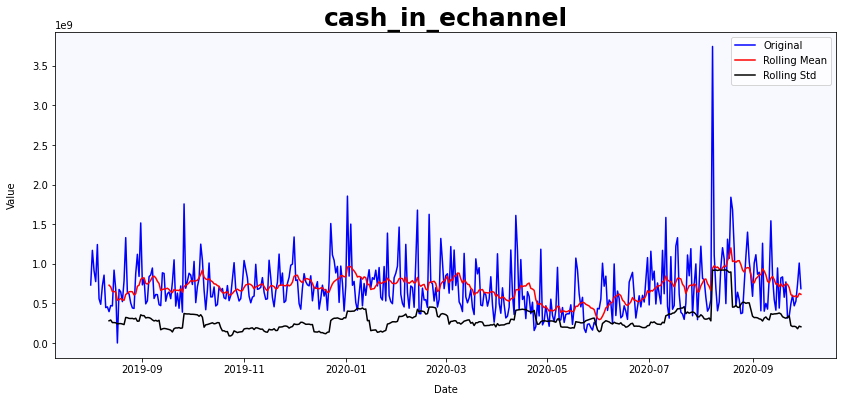

Results of Dickey Fuller Test: cash_in_echannel
Test Statistic                  -2.720485
p-value                          0.070560
#Lags Used                      14.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64
weak evidence against null hypothesis,indicating it is non-stationary 




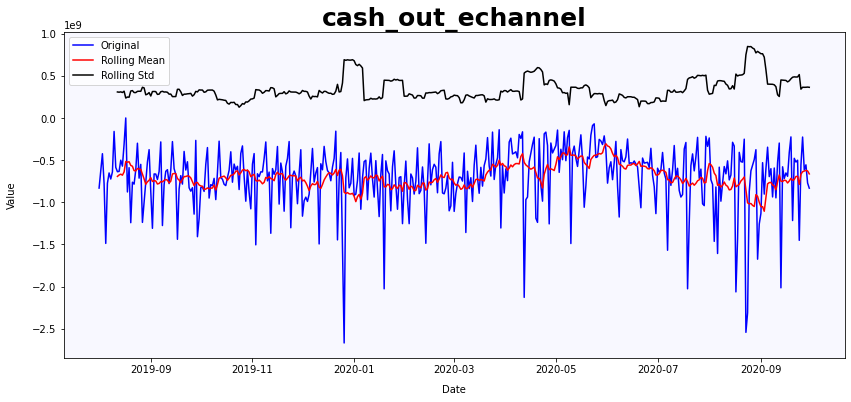

Results of Dickey Fuller Test: cash_out_echannel
Test Statistic                  -3.591457
p-value                          0.005926
#Lags Used                      13.000000
Number of Observations Used    413.000000
Critical Value (1%)             -3.446283
Critical Value (5%)             -2.868564
Critical Value (10%)            -2.570511
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




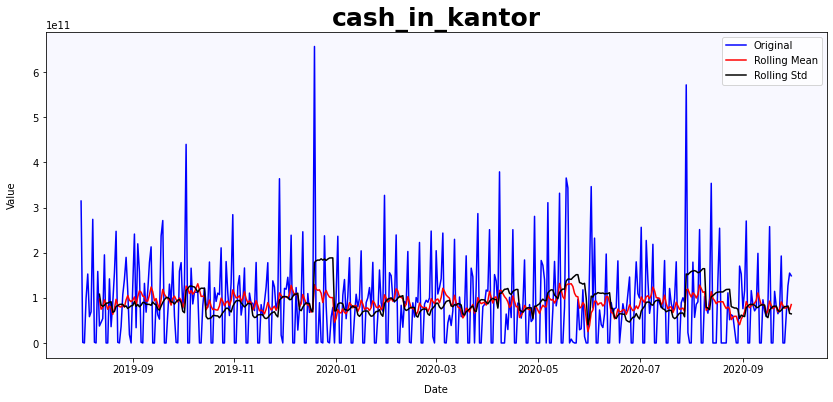

Results of Dickey Fuller Test: cash_in_kantor
Test Statistic                -6.052088e+00
p-value                        1.270451e-07
#Lags Used                     1.800000e+01
Number of Observations Used    4.080000e+02
Critical Value (1%)           -3.446480e+00
Critical Value (5%)           -2.868650e+00
Critical Value (10%)          -2.570557e+00
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




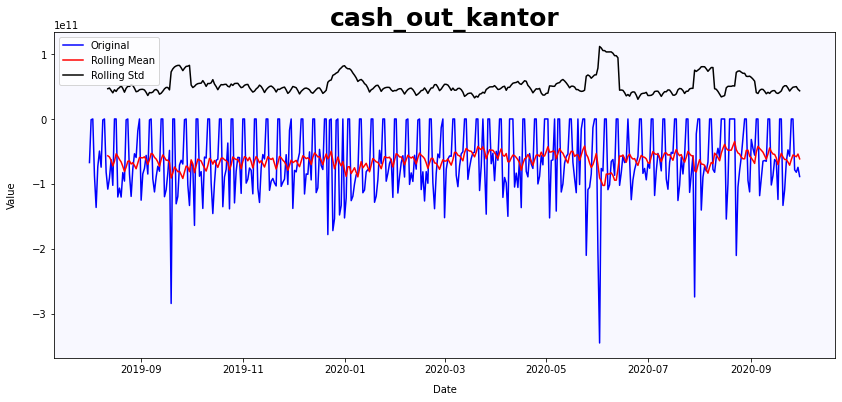

Results of Dickey Fuller Test: cash_out_kantor
Test Statistic                  -4.605750
p-value                          0.000126
#Lags Used                      14.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




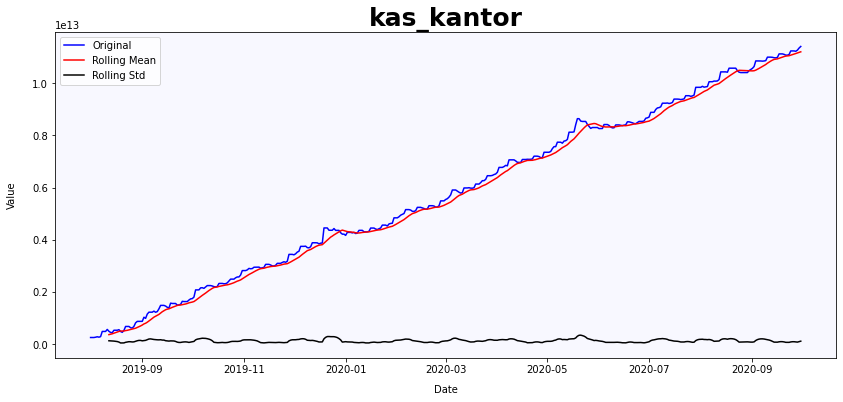

Results of Dickey Fuller Test: kas_kantor
Test Statistic                  -0.221378
p-value                          0.935925
#Lags Used                      14.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64
weak evidence against null hypothesis,indicating it is non-stationary 




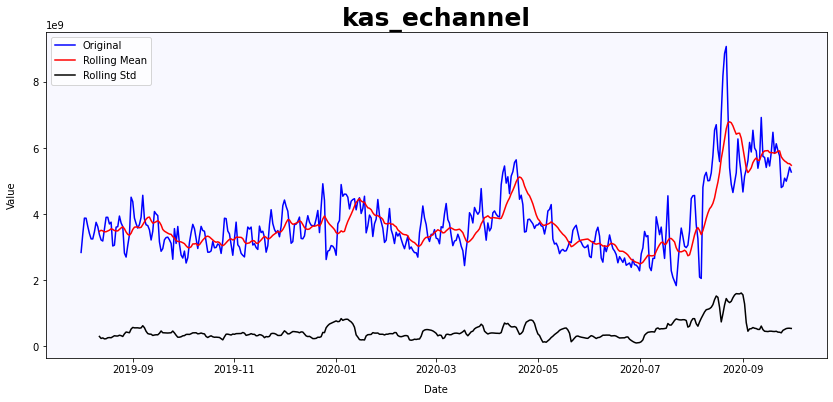

Results of Dickey Fuller Test: kas_echannel
Test Statistic                  -2.062965
p-value                          0.259665
#Lags Used                      14.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64
weak evidence against null hypothesis,indicating it is non-stationary 




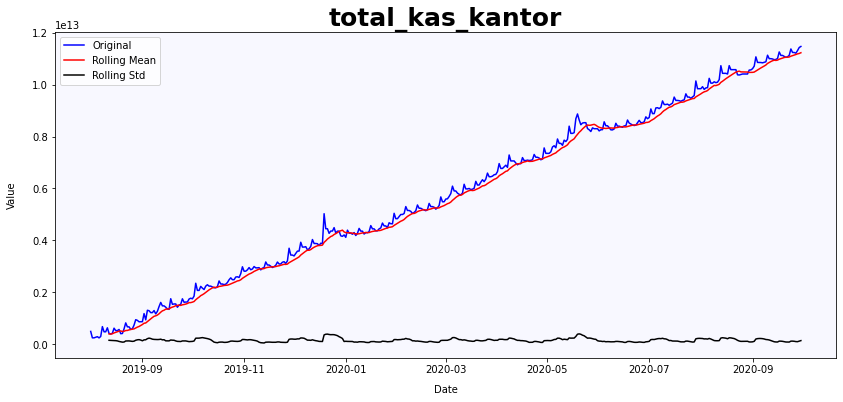

Results of Dickey Fuller Test: total_kas_kantor
Test Statistic                  -0.261161
p-value                          0.930828
#Lags Used                      17.000000
Number of Observations Used    409.000000
Critical Value (1%)             -3.446440
Critical Value (5%)             -2.868633
Critical Value (10%)            -2.570548
dtype: float64
weak evidence against null hypothesis,indicating it is non-stationary 




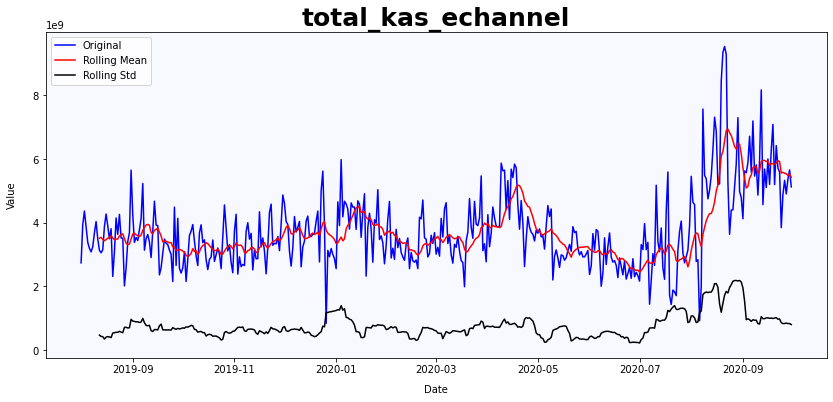

Results of Dickey Fuller Test: total_kas_echannel
Test Statistic                  -2.069366
p-value                          0.257010
#Lags Used                      14.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64
weak evidence against null hypothesis,indicating it is non-stationary 




In [ ]:
for x in df_cash.columns:
  stationarity_test(df_cash,x)

1. menggunakan test ADF, kita bisa melihat bahwa data total kas dan total echannel sama-sama memiliki kondisi non stationer (p_value > 0.05).

2. secara visualisasi, untuk data kas_kantor, rolling mean terlihat mengikuti tren data sedangkan rolling std atau variance cenderung mendatar, hal ini menunjukkan bahwa data kas kantor cendrung memiliki kondisi non-stationer terhadap mean, sehingga untuk tranformasi bisa menggunakan differensiasi

3. berbeda dengan kas kantor, kas echannel cenderung tidak naik dan baru mulai mengalami trend kenaikan pada july keatas, juga terlihat bahwa rolling mean dan tolling std terlihat mengikuti perubahan data, sehingga ada dua kemungkinan:
  1. data memiliki kondisi mean non-stationer (dilakukan differencing)
  2. data memiliki kondisi mean dan std non - stationer (data ditransformasi terlibih dulu , baru di differencing)

#### Stationarity in mean (acf pacf)

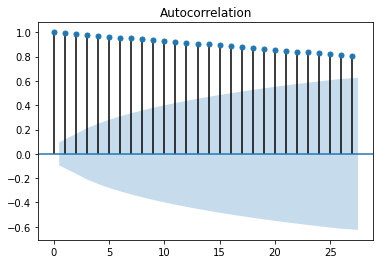

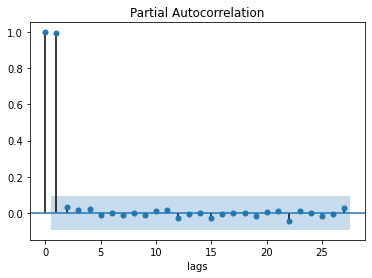

In [ ]:
plot_acf(df_cash['total_kas_kantor'])
plot_pacf(df_cash['total_kas_kantor'])
plt.xlabel('lags')
plt.show()

dapat dilihat bahwa
koefisien autokorelasi berbeda secara
signifikan dari nol dan mengecil secara
perlahan sedangkan semua koefisien
autokorelasi parsial mendekati nol setelah lag
pertama. Kedua hal tersebut menunjukkan
bahwa data bersifat tidak stasioner khususnya
tidak stasioner dalam rata-rata, 

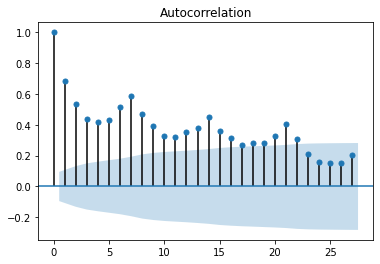

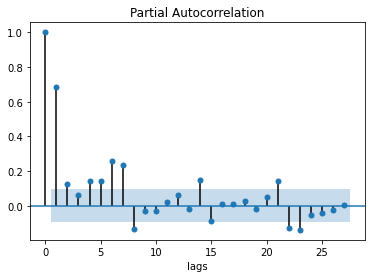

In [ ]:
plot_acf(df_cash['total_kas_echannel'])
plot_pacf(df_cash['total_kas_echannel'])
plt.xlabel('lags')
plt.show()

pada kas_echannel, selain menunjukkan autokorelasi pada plot acf, terlihat grfik naik turun secara bertahap setiap 7 lag yang mengindikasikan adanya kondisi seasonal pada data tersebut

overall, acf pacf menunjukkan data memiliki kondisi tidak stationer secara mean sehingga untuk transformasi akan menggunakan diff transformastion

### check residual and seasonal

In [ ]:
data_res = df_cash[['total_kas_kantor', 'total_kas_echannel']]
additive_kantor = seasonal_decompose(data_res['total_kas_kantor'])
additive_echannel = seasonal_decompose(data_res['total_kas_echannel'])

#### kantor

Text(0.5, 0.98, 'Additive Decompose')

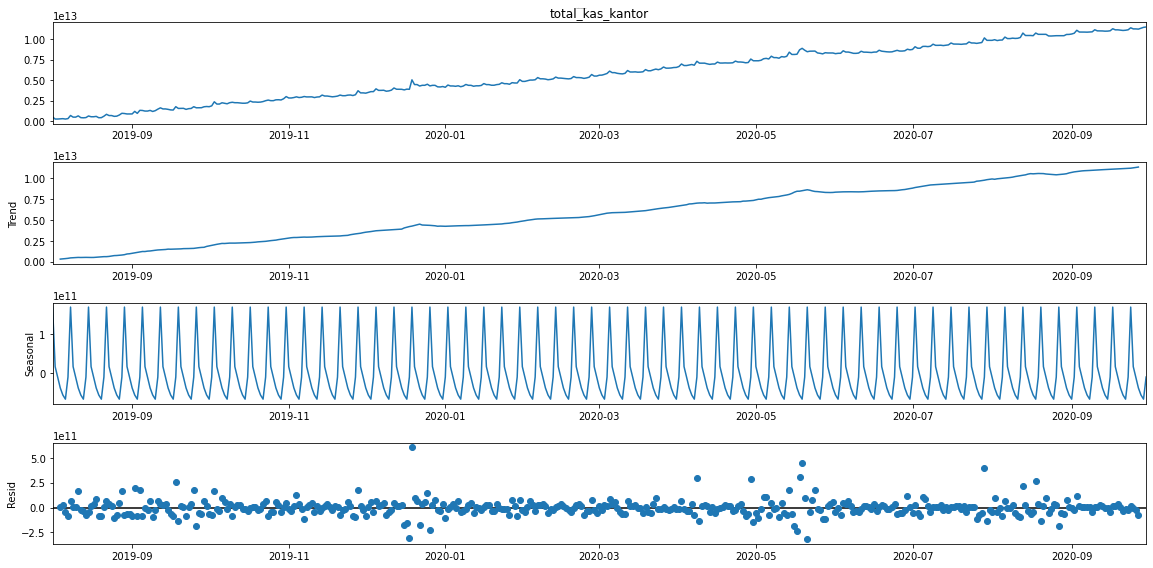

In [ ]:
plt.rcParams.update({'figure.figsize': (16,8)})
additive_kantor.plot().suptitle('Additive Decompose', fontsize=0)

#### echannel

Text(0.5, 0.98, 'Additive Decompose')

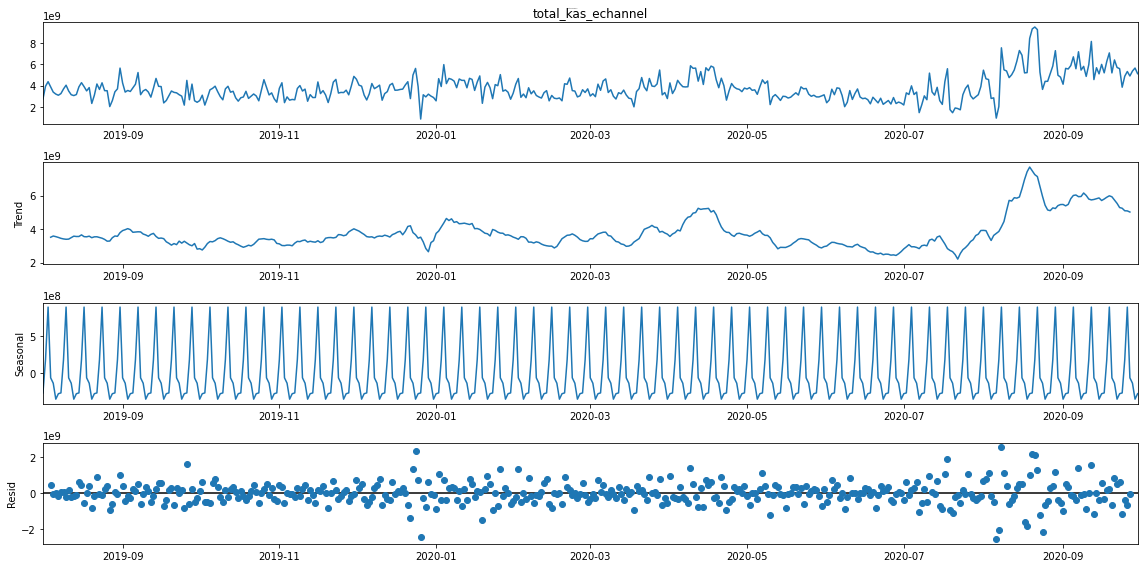

In [ ]:
plt.rcParams.update({'figure.figsize': (16,8)})
additive_echannel.plot().suptitle('Additive Decompose', fontsize=0)

terlihat kedua data memiliki pola seasonal , atau pola perulangan pada datanya dengan kondisi sangat padat (perulangan tidak perbulan atau pertahun namun per beberapa hari)

## Mean Transformation

### diferentiation transformation

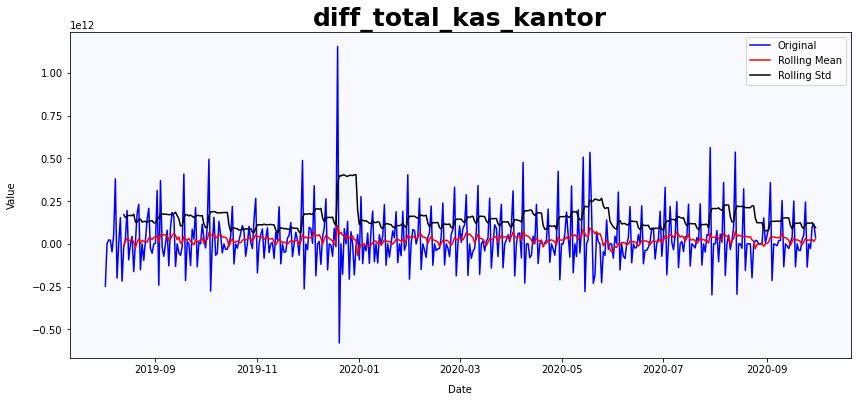

Results of Dickey Fuller Test: diff_total_kas_kantor
Test Statistic                  -5.101614
p-value                          0.000014
#Lags Used                      16.000000
Number of Observations Used    409.000000
Critical Value (1%)             -3.446440
Critical Value (5%)             -2.868633
Critical Value (10%)            -2.570548
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




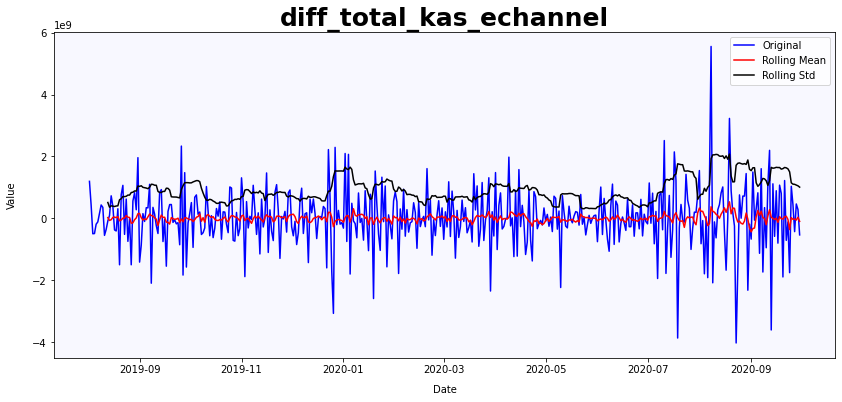

Results of Dickey Fuller Test: diff_total_kas_echannel
Test Statistic                -8.812632e+00
p-value                        1.972423e-14
#Lags Used                     1.200000e+01
Number of Observations Used    4.130000e+02
Critical Value (1%)           -3.446283e+00
Critical Value (5%)           -2.868564e+00
Critical Value (10%)          -2.570511e+00
dtype: float64
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




In [ ]:
diff_df_cash = df_cash[['total_kas_kantor', 'total_kas_echannel']]
diff_df_cash['diff_total_kas_echannel'] = diff_df_cash['total_kas_echannel'] - diff_df_cash['total_kas_echannel'].shift(1)
diff_df_cash['diff_total_kas_kantor'] = diff_df_cash['total_kas_kantor'] - diff_df_cash['total_kas_kantor'].shift(1)
diff_df_cash = diff_df_cash.dropna(inplace = False)

stationarity_test(diff_df_cash, 'diff_total_kas_kantor')
stationarity_test(diff_df_cash, 'diff_total_kas_echannel')

### Check acf pacf after differencing

#### kantor

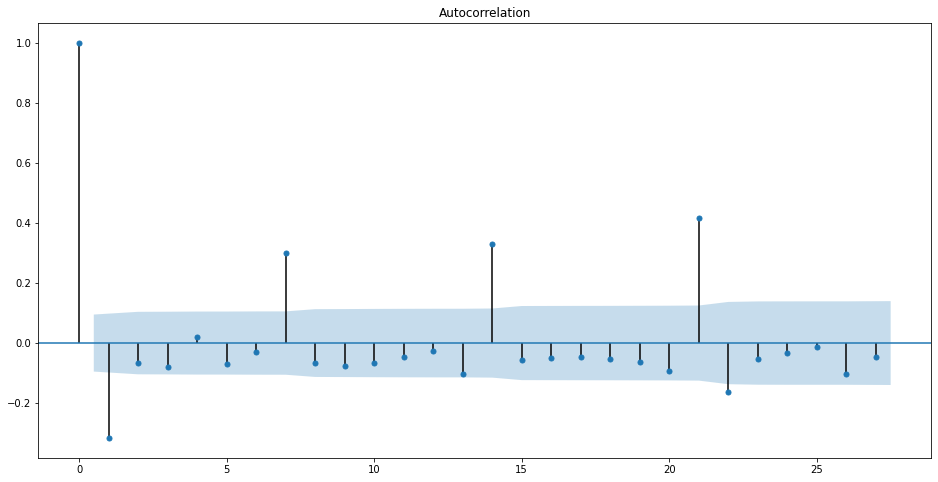

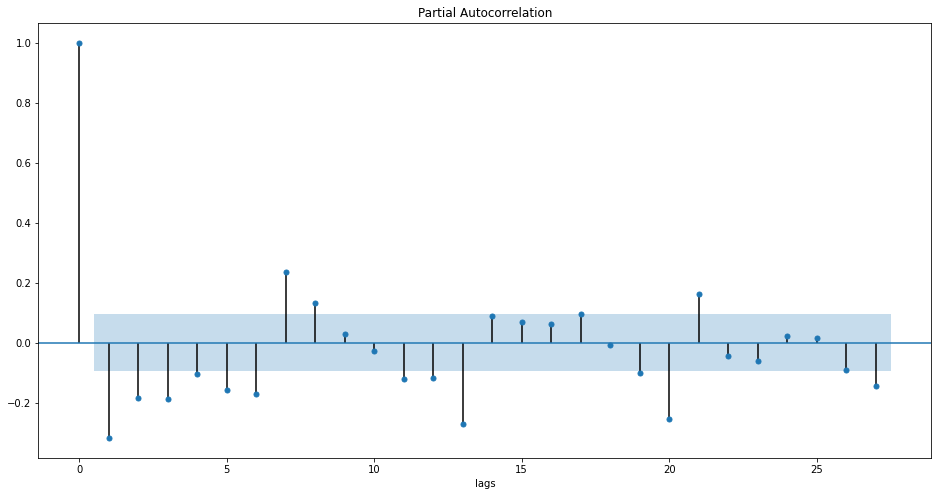

In [ ]:
plot_acf(diff_df_cash['diff_total_kas_kantor'])
plot_pacf(diff_df_cash['diff_total_kas_kantor'])
plt.xlabel('lags')
plt.show()

pada ar terlihat bahwa ada perulangan setiap 6 lag, sehingga kita bisa mengasumsikan ar = 6

#### echannel

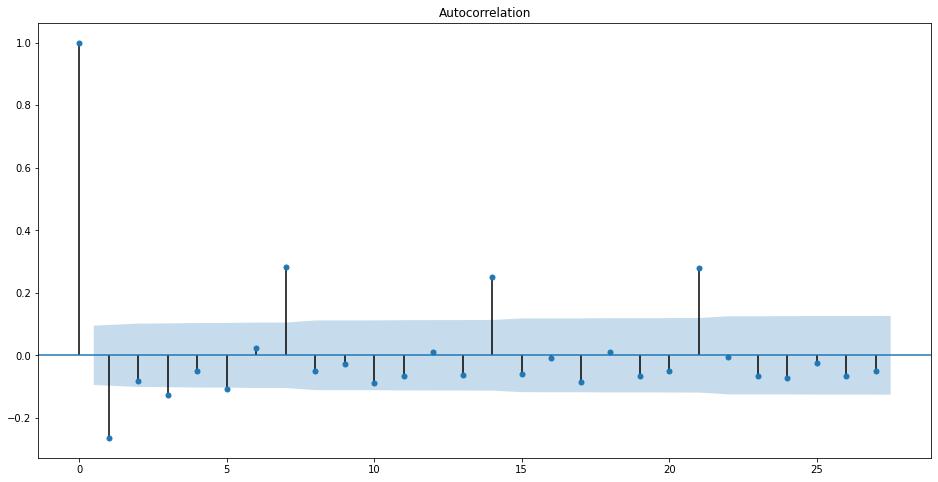

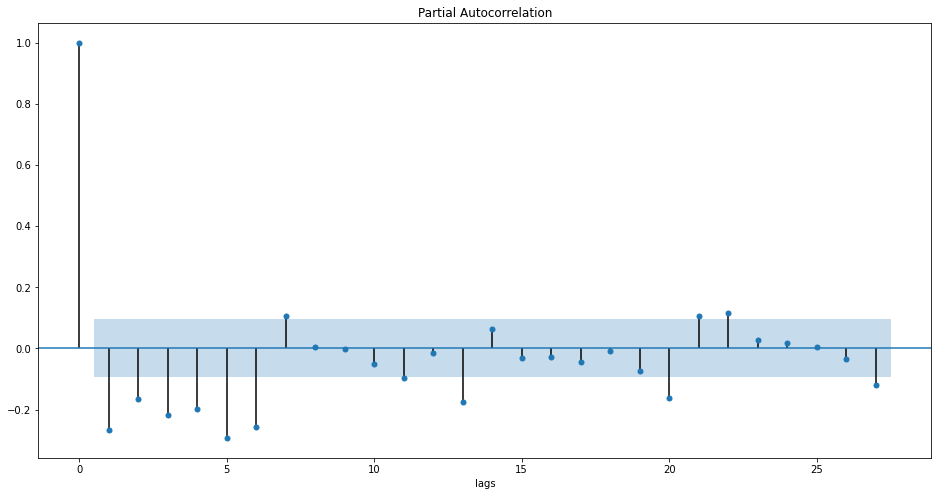

In [ ]:
plot_acf(diff_df_cash['diff_total_kas_echannel'])
plot_pacf(diff_df_cash['diff_total_kas_echannel'])
plt.xlabel('lags')
plt.show()

data log_kantor menunjukkan dying down pada acf, dan cut_off pada pacf

data melewati selang kepercayaan pada lag ke 7

data log echannel menunjukkan cut_off pada kedua acf dan pacf

## ARIMA

ar,i,ma

#### Kantor

In [ ]:
# Create Training data
train_kantor = diff_df_cash.loc[:'2020-08-31',['total_kas_kantor','diff_total_kas_kantor']]
test_kantor = diff_df_cash.loc['2020-09-01':,['total_kas_kantor','diff_total_kas_kantor']]

sebenarnya kita bisa menggunakan auto_arima untuk langsung mendapatkan best parameter, dan memasukkan model dari auto_arima untuk melakukan forecasting, namun untuk bagian auto arima ini, saya hanya gunakan untuk mencari best parameter menggunakan differencing, lalu gunakan best parameter dri data differencing untuk melakukan training dan forecasting pada data real

In [ ]:
#find best parameter for arima
model_a = pm.auto_arima(train_kantor.diff_total_kas_kantor,
                        d=1, 
                        start_p=0, start_q=0,     
                        max_p=6, max_q=6, # maximum p and q
                        start_P=0, D=1, start_Q=0, max_P=3, max_D=3,max_Q=3,
                        m=7,              
                        seasonal=False,   # Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(model_a.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21864.625, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21693.012, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21509.133, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21862.629, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21476.801, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21468.862, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21627.454, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21461.333, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=21576.285, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=21454.685, Time=0.37 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=21556.018, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=21441.879, Time=0.49 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=21540.650, Time=0.14 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=21413.250, Time=0.64 sec
 ARIMA(6,1,0)(0,0,0

1. salah satu parameter yang digunakan untuk melihat apakah model ARIMA layak digunakan adalah residu data setelah dilakukan permodelan mengikuti asumsi white noise (residu bersifat distribusi normal, dan residu tidak berautokorelasi atau saling independen antar residu). salah satu cara menguji apakah residu saling independent adalah menggunakan uji Ljung-Box. Dan dari uji Ljung-Box didapatkan P-Value sebesar 0,57 (p-Value > 0.05) yang artinya bahwa data residu bersifat independent.


autogregredif lag1

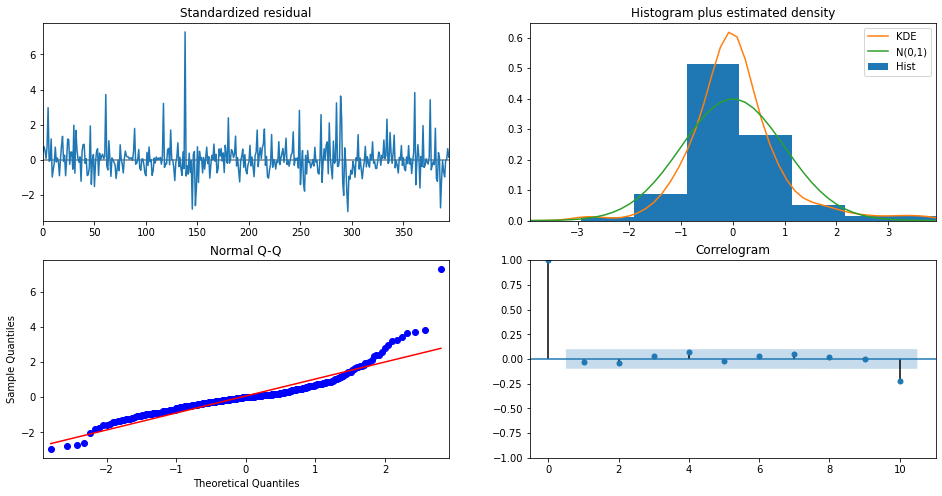

In [ ]:
model_a.plot_diagnostics(figsize=(16, 8))
plt.show()

2. pada plot histrogram residu, terlihat residu sudah mendekati asumsi distrbusi normal (asumsi white noise) sehingga arima dengan parameter diatas layak digunakan untuk permodelan

In [ ]:
# Build Model
model_a_kantor = ARIMA(train_kantor.total_kas_kantor, order=(6,1,3))  
fitted_a_kantor = model_a_kantor.fit()
resid_a_kantor = fitted_a_kantor.resid
print(fitted_a_kantor.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.total_kas_kantor   No. Observations:                  395
Model:                 ARIMA(6, 1, 3)   Log Likelihood              -10657.708
Method:                       css-mle   S.D. of innovations   124855833585.043
Date:                Sat, 09 Jan 2021   AIC                          21337.415
Time:                        06:12:54   BIC                          21381.183
Sample:                    08-03-2019   HQIC                         21354.756
                         - 08-31-2020                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     2.612e+10   2.93e+09      8.925      0.000    2.04e+10    3.19e+10
ar.L1.D.total_kas_kantor    -0.3407      0.001   -245.437      0.000      -0.343      -0.

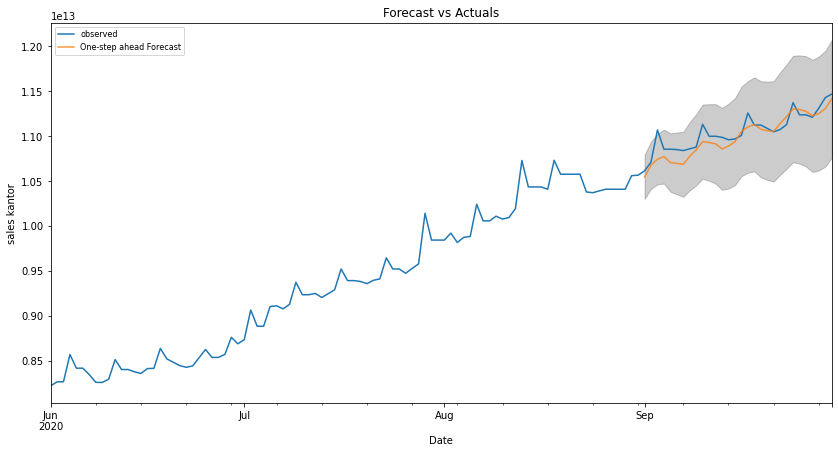

In [ ]:
# Forecast
fc_kantor, se, conf_kantor = fitted_a_kantor.forecast(30, alpha=0.05)  # 95% conf

#make pandas series
pred_kantor = pd.Series(fc_kantor, index=test_kantor.index)
lower_series = pd.Series(conf_kantor[:, 0], index=test_kantor.index)
upper_series = pd.Series(conf_kantor[:, 1], index=test_kantor.index)


#plot
ax = diff_df_cash.total_kas_kantor.loc['2020-06-01':].plot(label='observed')
pred_kantor.plot(ax=ax, label='One-step ahead Forecast', alpha=.8, figsize=(14, 7))

ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('sales kantor')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
mean_squared_log_error(test_kantor['total_kas_kantor'], fc_kantor)

9.479244845586666e-05

#### echannel

In [ ]:
# Create Training and Test
train_echannel = diff_df_cash.loc[:'2020-08-31',['total_kas_echannel','diff_total_kas_echannel']]
test_echannel = diff_df_cash.loc['2020-09-01':,['total_kas_echannel','diff_total_kas_echannel']]

In [ ]:
#find parameter
model_ae = pm.auto_arima(train_echannel.diff_total_kas_echannel, 
                         d=1, 
                        start_p=0, start_q=0,       
                        max_p=6, max_q=6, # maximum p and q
                        start_P=0, D=1, start_Q=0, max_P=3, max_D=3,max_Q=3,
                        m=7,              
                        seasonal=False,   # Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(model_ae.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17798.659, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17660.233, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17475.283, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17796.662, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17462.622, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17456.095, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17609.627, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17446.424, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17573.877, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17385.790, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17390.766, Time=0.82 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17381.899, Time=1.05 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=17366.324, Time=0.61 sec
 ARIMA(5,1,1)(0,0,0)[0] i

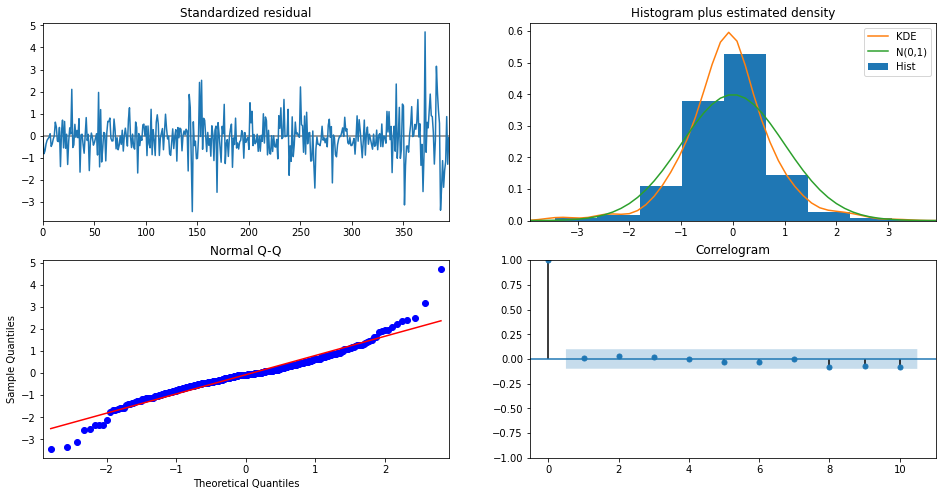

In [ ]:
model_ae.plot_diagnostics(figsize=(16, 8))
plt.show()

Suatu proses { t} disebut proses white noise jika series-nya terdiri dari
variabel random yang tidak berkorelasi dan berdistribusi normal 


Gambar 3 memperlihatkan residu mengikuti garis diagonal, yang berarti residu
berdistribusi normal. Karena residu bersifat random dan berdistribusi normal, maka
residu memenuhi asumsi white noise

In [ ]:
# Build Model
model_a_echannel = ARIMA(train_echannel.total_kas_echannel, order=(6, 1, 1))  
fitted_a_echannel = model_a_echannel.fit()
resid_a_echannel = fitted_a_echannel.resid
print(fitted_a_echannel.summary())


                              ARIMA Model Results                               
Dep. Variable:     D.total_kas_echannel   No. Observations:                  395
Model:                   ARIMA(6, 1, 1)   Log Likelihood               -8656.924
Method:                         css-mle   S.D. of innovations      796542597.392
Date:                  Sat, 09 Jan 2021   AIC                          17331.847
Time:                          06:13:04   BIC                          17367.657
Sample:                      08-03-2019   HQIC                         17346.036
                           - 08-31-2020                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        2.17e+06   1.27e+07      0.170      0.865   -2.28e+07    2.71e+07
ar.L1.D.total_kas_echannel    -0.7200      0.187     -3.844      0.

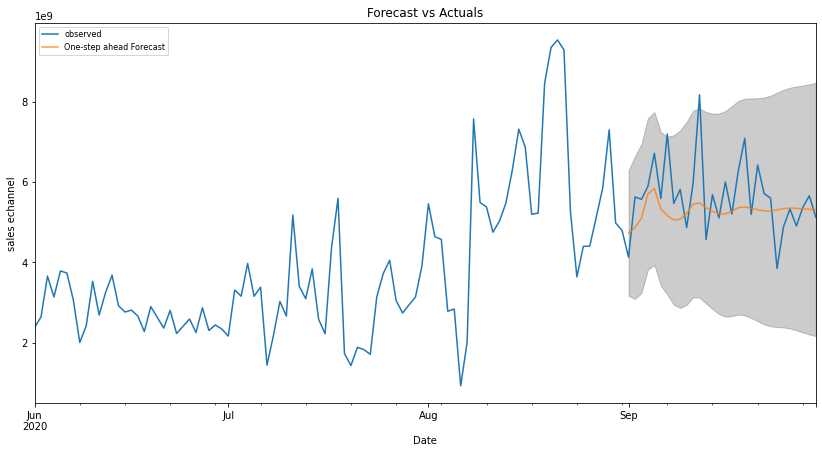

In [ ]:
# Forecast
fc_echannel, se, conf_echannel = fitted_a_echannel.forecast(30, alpha=0.05)  # 95% conf

#make pandas series
pred_echannel = pd.Series(fc_echannel, index=test_echannel.index)
lower_series = pd.Series(conf_echannel[:, 0], index=test_echannel.index)
upper_series = pd.Series(conf_echannel[:, 1], index=test_echannel.index)


#plot
ax = diff_df_cash.total_kas_echannel.loc['2020-06-01':].plot(label='observed')
pred_echannel.plot(ax=ax, label='One-step ahead Forecast', alpha=.8, figsize=(14, 7))

ax.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('sales echannel')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
mean_squared_log_error(test_echannel['total_kas_echannel'], fc_echannel)

0.023396452942347355

### total

In [ ]:
fc_total = fc_kantor + fc_echannel
test_total = test_kantor['total_kas_kantor'] + test_echannel['total_kas_echannel']

mean_squared_log_error(test_total, fc_total)

9.512784395259856e-05

### SARIMA


#### kantor

In [ ]:
train_kantor = diff_df_cash.loc[:'2020-08-31',['total_kas_kantor','diff_total_kas_kantor']]
test_kantor = diff_df_cash.loc['2020-09-01':,['total_kas_kantor','diff_total_kas_kantor']]

In [ ]:
#find parameter for sarimax
model_s = pm.auto_arima(train_kantor.diff_total_kas_kantor,
                        d=1, #we use differencing = 1
                        start_p=0, start_q=0,
                        max_p=6, max_q=6, # maximum p and q
                        start_P=0, D=1, start_Q=0, max_P=6, max_D=3,max_Q=6,
                        m=7,              
                        seasonal=True,   # Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(model_s.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=21638.296, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=21325.185, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=21099.633, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=21099.452, Time=0.56 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=21100.692, Time=1.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=21101.169, Time=1.20 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=21099.207, Time=0.89 sec
 ARIMA(0,1,1)(0,1,3)[7]             : AIC=21101.107, Time=2.06 sec
 ARIMA(0,1,1)(1,1,3)[7]             : AIC=inf, Time=3.97 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=21412.362, Time=0.38 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=21061.732, Time=0.89 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=21061.304, Time=0.49 sec
 ARIMA(1,1,1)(0,1,0)[7]             :

In [ ]:
mod_kantor = sm.tsa.statespace.SARIMAX(train_kantor.total_kas_kantor,
                                order=(3, 1, 2),
                                seasonal_order=(0, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_kantor = mod_kantor.fit()

print(results_kantor.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2175      0.472      0.461      0.645      -0.707       1.142
ar.L2         -0.4261      0.198     -2.154      0.031      -0.814      -0.038
ar.L3         -0.2450      0.148     -1.660      0.097      -0.534       0.044
ma.L1         -0.6850      0.481     -1.425      0.154      -1.627       0.257
ma.L2          0.5057      0.342      1.479      0.139      -0.165       1.176
ma.S.L7       -0.8651      0.033    -25.993      0.000      -0.930      -0.800
sigma2      2.764e+22   2.95e-23   9.37e+44      0.000    2.76e+22    2.76e+22


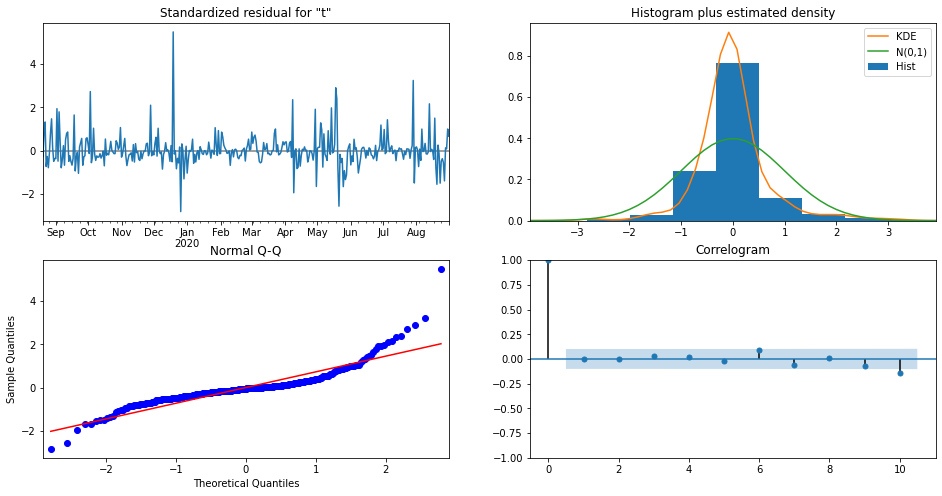

In [ ]:
results_kantor.plot_diagnostics(figsize=(16, 8))
plt.show()

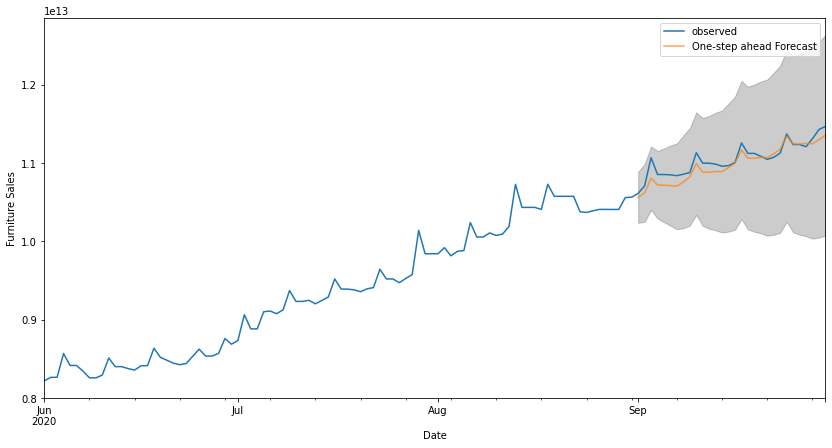

In [ ]:
pred_kantor = results_kantor.get_prediction(start=pd.to_datetime('2020-09-01'), end=pd.to_datetime('2020-09-30'), dynamic=False)
pred_ci_kantor = pred_kantor.conf_int()

ax = diff_df_cash.total_kas_kantor.loc['2020-06-01':].plot(label='observed')
pred_kantor.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci_kantor.index,
                pred_ci_kantor.iloc[:, 0],
                pred_ci_kantor.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted_kantor = pred_kantor.predicted_mean
y_truth_kantor = diff_df_cash.total_kas_kantor['2020-09-01':]


mean_squared_log_error(y_truth_kantor, y_forecasted_kantor)

7.821190662364806e-05

#### echannel

In [ ]:
# Create Training and Test
train_echannel = diff_df_cash.loc[:'2020-08-31',['total_kas_echannel','diff_total_kas_echannel']]
test_echannel = diff_df_cash.loc['2020-09-01':,['total_kas_echannel','diff_total_kas_echannel']]

In [ ]:
model_k = pm.auto_arima(train_echannel.diff_total_kas_echannel,
                        d=1,
                        start_p=0, start_q=0,
                        max_p=5, max_q=5, 
                        start_P=0, D=1, start_Q=0, max_P=5, max_D=5,max_Q=5,
                        m=7,             
                        seasonal=True,  
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)

print(model_k.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=17686.052, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=17412.866, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=17490.374, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=17363.771, Time=0.46 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=17338.377, Time=0.89 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=17336.121, Time=1.31 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=17334.574, Time=1.88 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=17328.315, Time=5.29 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=17326.337, Time=3.31 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=17326.322, Time=1.65 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=17324.332, Time=0.81 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=17326.005, Time=0.29 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=17326.328, Time=1.41 sec
 ARIMA(1,1,0)(1,1,2)[7]  

In [ ]:
mod_echannel = sm.tsa.statespace.SARIMAX(train_echannel.total_kas_echannel,
                                order=(5, 1, 0),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_echannel = mod_echannel.fit()

print(results_echannel.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.084     -4.952      0.000      -0.577      -0.250
ar.L2         -0.3370      0.071     -4.718      0.000      -0.477      -0.197
ar.L3         -0.3307      0.084     -3.945      0.000      -0.495      -0.166
ar.L4         -0.2595      0.066     -3.916      0.000      -0.389      -0.130
ar.L5         -0.2885      0.091     -3.184      0.001      -0.466      -0.111
ar.S.L12      -0.0876      0.103     -0.848      0.397      -0.290       0.115
ar.S.L24      -0.1411      0.117     -1.206      0.228      -0.370       0.088
ma.S.L12      -0.8175      0.070    -11.626      0.000      -0.955      -0.680
sigma2      1.279e+18   4.65e-20   2.75e+37      0.000    1.28e+18    1.28e+18


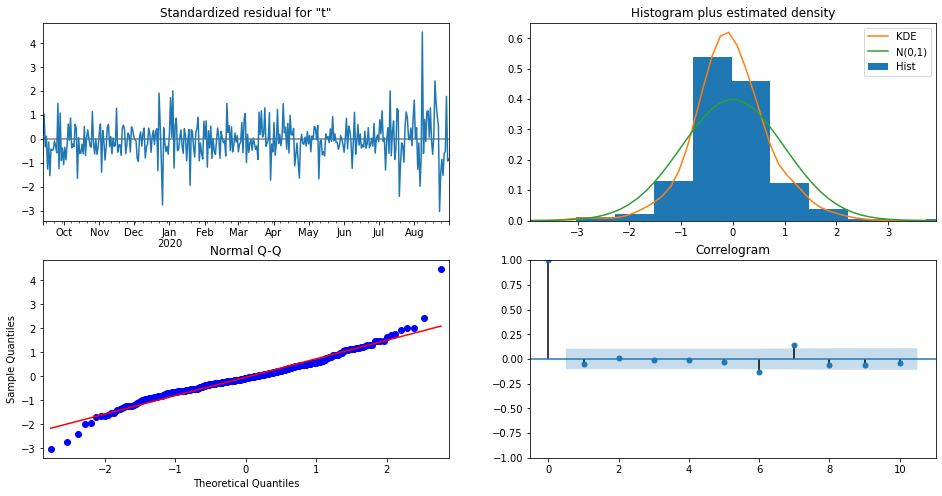

In [ ]:
results_echannel.plot_diagnostics(figsize=(16, 8))
plt.show()

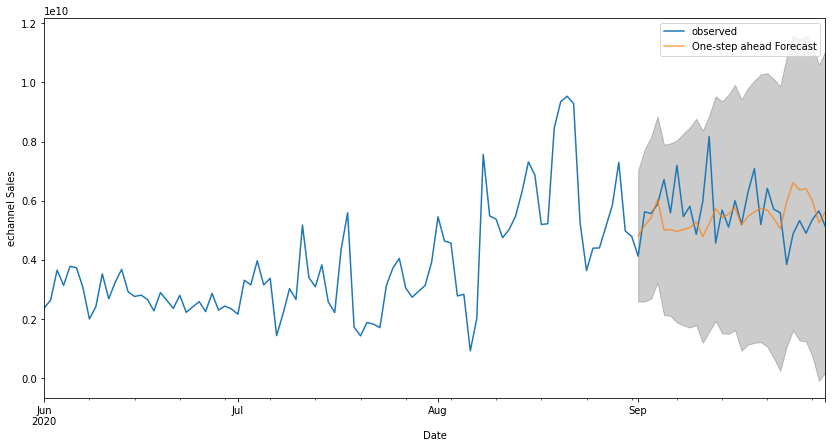

In [ ]:
pred_echannel = results_echannel.get_prediction(start=pd.to_datetime('2020-09-01'), end=pd.to_datetime('2020-09-30'), dynamic=False)
pred_ci_echannel = pred_echannel.conf_int()

ax = diff_df_cash.total_kas_echannel.loc['2020-06-01':].plot(label='observed')
pred_echannel.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci_echannel.index,
                pred_ci_echannel.iloc[:, 0],
                pred_ci_echannel.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('echannel Sales')
plt.legend()

plt.show()

In [ ]:
y_forecasted_echannel = pred_echannel.predicted_mean
y_truth_echannel = diff_df_cash.total_kas_echannel['2020-09-01':]


mean_squared_log_error(y_truth_echannel, y_forecasted_echannel)

0.03776428689166196

#### All

In [ ]:
fc_total = y_forecasted_kantor + y_forecasted_echannel
test_total = test_kantor['total_kas_kantor'] + test_echannel['total_kas_echannel']

pr, cek seasonalitas

In [ ]:
mean_squared_log_error(test_total.values, fc_total.values)

7.876020415111267e-05